# 13. Loading and Preprocessing Data with TensorFlow

#### Setup

In [1]:
import os
from contextlib import ExitStack
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras, data
from keras import (
    callbacks,
    layers,
    Sequential,
    optimizers,
)
from tensorflow.train import Example, Feature, Features, BytesList, Int64List, FloatList
import tensorflow_datasets as tfds
import tensorflow_hub as hub


In [2]:
DATASET_PATH = os.path.join('/', 'Users', 'mmenendezg', 'Developer', 'Datasets', 'fashion_mnist')
SHUFFLE_BUFFER = 60000
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 4096

os.makedirs(DATASET_PATH, exist_ok=True)

In [3]:
def get_log_dir():
    datetime_dir = datetime.now().strftime("%Y%m%d_%H%M")
    log_dir = os.path.join('..', "..", "reports", "logs", datetime_dir)
    return log_dir

#### 9. Load the Fashion MNIST dataset (introduced in Chapter 10); split it into a training set, a validation set, and a test set; shuffle the training set; and save each dataset to multiple TFRecord files. Each record should be a serialized Example protobuf with two features: the serialized image (use tf.io.serialize_tensor() to serialize each image), and the label.⁠ Then use tf.data to create an efficient dataset for each set. Finally, use a Keras model to train these datasets, including a preprocessing layer to standardize each input feature. Try to make the input pipeline as efficient as possible, using TensorBoard to visualize profiling data.

In [4]:
tf.random.set_seed(1992)

train_set, valid_set, test_set = tfds.load(
    name="fashion_mnist",
    data_dir=DATASET_PATH,
    split=["train[:90%]", "train[90%:]", "test"],
    as_supervised=True
)

Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



In [5]:
def create_example(image, label):
    """This function creates an example protobufs using the image 
    and label of the `fashion_mnist` dataset

    Args:
        image (tf.Tensor): Array containing the values of the image
        label (int): Value of the class of the image

    Returns:
        binary protobuf: Protobuf containing the image and the label 
    """
    image_data = tf.io.serialize_tensor(image)
    label_data = tf.io.serialize_tensor(label)
    feature = {
        "image": Feature(bytes_list=BytesList(value=[image_data.numpy()])),
        "label": Feature(int64_list=Int64List(value=[label.numpy()])),
    }
    
    return Example(
        features=Features(
            feature=feature
        )
    )


def save_protobufs(dataset, set_type="train", n_shards=10):
    """This function divides the set into multiple mini sets,
    and saves the images as protobufs in several files

    Args:
        set (tf.data.Dataset): set of tuples (images, target) of the fashion_mnist dataset
    """
    if set_type == "train":
        dataset.shuffle(SHUFFLE_BUFFER)
    files = [
        f"{set_type}.tfrecord-{shard:05d}-of-{n_shards:05d}"
        for shard in range(n_shards)
    ]
    file_paths = [os.path.join(DATASET_PATH, file_path) for file_path in files]
    with ExitStack() as stack:
        writers = [stack.enter_context(tf.io.TFRecordWriter(file)) for file in file_paths]
        for index, (image, label) in dataset.enumerate():
            shard = index % n_shards
            example = create_example(image, label)
            writers[shard].write(example.SerializeToString())
    return file_paths

In [6]:
train_files = save_protobufs(train_set, 'train')
valid_files = save_protobufs(valid_set, 'valid')
test_files = save_protobufs(test_set, 'test')

In [7]:
def get_record(tfrecord):
    feature_descriptions = {
        "image": tf.io.FixedLenFeature([], tf.string, default_value=""),
        "label": tf.io.FixedLenFeature([], tf.int64, default_value=-1),
    }
    example = tf.io.parse_single_example(tfrecord, feature_descriptions)
    image = tf.io.parse_tensor(example["image"], out_type=tf.uint8)
    image = tf.reshape(image, shape=[28, 28])
    return image, example["label"]


def mnist_dataset(file_paths, cache=True, shuffle_buffer_size=None):

    dataset = tf.data.TFRecordDataset(file_paths, num_parallel_reads=AUTOTUNE)

    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = (
        dataset.map(get_record, num_parallel_calls=AUTOTUNE)
        .batch(BATCH_SIZE)
        .prefetch(AUTOTUNE)
    )
    return dataset


In [8]:
train_set = mnist_dataset(train_files, shuffle_buffer_size=SHUFFLE_BUFFER)
valid_set = mnist_dataset(valid_files)
test_set = mnist_dataset(test_files)

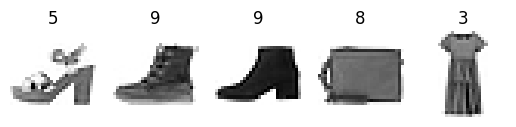

In [9]:
for x, y in train_set.take(1):
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(x[i].numpy(), cmap="binary")
        plt.axis("off")
        plt.title(str(y[i].numpy()))

In [10]:
tf.random.set_seed(1992)
tf.keras.backend.clear_session()

# Normalization of the data
sample_images = train_set.take(250).map(lambda image, label: image)
normalizer = layers.Normalization(input_shape=[28, 28])
normalizer.adapt(sample_images)

# Callbacks
tensorboard_cb = callbacks.TensorBoard(
    log_dir=get_log_dir(), profile_batch=10, histogram_freq=1
)

model = Sequential(
    [
        normalizer,
        layers.Flatten(),
        layers.Dense(100, activation="relu"),
        layers.Dense(10, activation="softmax"),
    ]
)
model.compile(
    loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer="nadam"
)

model.fit(train_set, epochs=50, validation_data=valid_set, callbacks=[tensorboard_cb])


Epoch 1/50
14/14 [==============================] - 1s 70ms/step - loss: 1.3607 - accuracy: 0.5495 - val_loss: 0.7148 - val_accuracy: 0.7525
Epoch 2/50
14/14 [==============================] - 1s 61ms/step - loss: 0.6364 - accuracy: 0.7777 - val_loss: 0.5667 - val_accuracy: 0.8005
Epoch 3/50
14/14 [==============================] - 1s 60ms/step - loss: 0.5246 - accuracy: 0.8164 - val_loss: 0.4895 - val_accuracy: 0.8243
Epoch 4/50
14/14 [==============================] - 1s 61ms/step - loss: 0.4756 - accuracy: 0.8304 - val_loss: 0.4767 - val_accuracy: 0.8255
Epoch 5/50
14/14 [==============================] - 1s 58ms/step - loss: 0.4481 - accuracy: 0.8404 - val_loss: 0.4319 - val_accuracy: 0.8435
Epoch 6/50
14/14 [==============================] - 1s 61ms/step - loss: 0.4242 - accuracy: 0.8496 - val_loss: 0.4469 - val_accuracy: 0.8388
Epoch 7/50
14/14 [==============================] - 1s 59ms/step - loss: 0.4101 - accuracy: 0.8542 - val_loss: 0.4021 - val_accuracy: 0.8563
Epoch 8/50
14

#### 10. In this exercise you will download a dataset, split it, create a tf.data.Dataset to load it and preprocess it efficiently, then build and train a binary classification model containing an Embedding layer:

#### - Download the Large Movie Review Dataset, which contains 50,000 movie reviews from the Internet Movie Database (IMDb). The data is organized in two directories, train and test, each containing a pos subdirectory with 12,500 positive reviews and a neg subdirectory with 12,500 negative reviews. Each review is stored in a separate text file. There are other files and folders (including preprocessed bag-of-words versions), but we will ignore them in this exercise.

#### - Split the test set into a validation set (15,000) and a test set (10,000).

#### - Use tf.data to create an efficient dataset for each set.

#### - Create a binary classification model, using a TextVectorization layer to preprocess each review.

#### - Add an Embedding layer and compute the mean embedding for each review, multiplied by the square root of the number of words (see Chapter 16). This rescaled mean embedding can then be passed to the rest of your model.

#### - Train the model and see what accuracy you get. Try to optimize your pipelines to make training as fast as possible.

#### - Use TFDS to load the same dataset more easily: tfds.load("imdb_reviews").